In [1]:
import igraph as ig
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_mutual_info_score as AMI
import partition_igraph
from matplotlib import pyplot as plt
from collections import Counter
import random
import pickle
import os
import seaborn as sns
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve
from scipy.sparse import csr_matrix
import scipy.sparse as sparse 
import time
from statistics import mode
from abcd_graph import ABCDGraph, ABCDParams
import csv
import subprocess
import sys
sys.path.append('../')
from CAS import *
from itertools import combinations


In [3]:
## DEV
# path = '/data/ABCDoo/'
# oNMI = '/work/home/fcthebe/Tools/oNMI/onmi' 

## MAC
path = '../Datasets/ABCDoo/' 
oNMI = '/Users/francois/Book/GraphMiningNotebooks/oNMI/onmi' 


In [4]:
## this assumes community 0 are outliers and 'gt' exists in graph G
## M: membership matrix
## S: score matrix (C or Beta)
def outliers_AUC(G, M, S):
    y = [int(x>0) for x in G.vs['gt']]
    x = np.array(S.max(axis=1).todense()).flatten()
    ctr = Counter(np.array(M.sum(axis=1)).flatten())
    print('With matrix M:\noutliers:',ctr[0])
    print('correct outliers:',sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(G.vs['gt']) == 0)))
    print('\nWith scores:\noutlier AUC:',AUC(y,x)) 
        
## Read ABCD+oo graph
def readGraph(xi=0.5, eta=1.5, rep=1):
    ## read edges, build graph
    fn = path+'networkfile'+str(xi)+'_'+str(eta)+'_'+str(rep)+'.txt'
    Edges = pd.read_csv(fn, sep='\t', header=None)-1
    G = ig.Graph.DataFrame(Edges, directed=False)
    ## read communities
    fn = path+'communityfile'+str(xi)+'_'+str(eta)+'_'+str(rep)+'.txt'
    L = []
    with open(fn, "r") as infile:
        for line in infile:
            x = line.split('\t')
            L.append([int(y)-1 for y in x[1].rstrip()[1:-1].split(',')]) ## map to 0-based
    G.vs['comms'] = L
    G.vs['n_comms'] = [len(x) for x in G.vs['comms']]
    return G
   
## calls the oNMI executable, format of inputs: list of lists (communities)
def compute_oNMI(First, Second):
    fn1 = '__'+str(random.random())[2:]
    with open(fn1,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(First)
    f.close()   

    fn2 = '__'+str(random.random())[2:]
    with open(fn2,"w") as f:
        wr = csv.writer(f, delimiter=" ")
        wr.writerows(Second)
    f.close()   
    x = float(subprocess.check_output([oNMI,fn1,fn2]).decode("utf-8").split()[1])
    _ = os.system('rm '+fn1)
    _ = os.system('rm '+fn2)
    return x

## ???
def memberships2list(S):
    L = []
    for i in range(len(S.indptr)-1):
        if S.indptr[i] == S.indptr[i+1]:
            L.append([0]) ## no membership == outlier (community 0)
        else:
            L.append(list(S.indices[S.indptr[i]:S.indptr[i+1]]+1)) ## 1-based
    return L

## given a list of node memberships, return list of communities
def mems2comms(X):
    nc = max(set([i for j in X for i in j]))+1  
    n = len(X)
    L = [[] for _ in range(nc)]
    for i in range(n):
        for j in X[i]:
            L[j].append(i)
    return L

def CPM(g, k=3):
    cls = list(map(set, g.cliques(min=k,max=k)))
    edgelist = []
    for i in range(len(cls)):
        edgelist.append((i,i))
    for i,j in combinations(range(len(cls)),2):
        if len(cls[i].intersection(cls[j])) >= (k-1):
            edgelist.append((i,j))
    cg = ig.Graph(edgelist, directed=False)
    clusters = cg.connected_components()
    L = []
    for cluster in clusters:
        members = set()
        for i in cluster:
            members.update(cls[i])
        L.append(set(g.vs[members]["name"]))
    return L


def EgoSplit(G, split='CC', algo='LP'):
    g = G.copy()
    ## implement ego-split approach with LP+LP and LP+ECG
    g.vs['original'] = g.vs['name']
    ## use the vertex names to avoid issues when vertices are re-mapped ...
    names = g.vs['name']
    ## step 1 - ego-net splits
    for nm in names:
        v = g.vs.find(nm).index
        n = g.neighbors(v)
        sg = g.subgraph(n)
        if split == 'LP':
            x = sg.community_label_propagation().membership
        else:
            x = sg.connected_components().membership
        if np.min(x)==-1:
            x = [i+1 for i in x]
        for j in set(x):
            g.add_vertex(name=nm+'.'+str(j),original=nm)

        l = sg.vs['name']
        for j in range(len(x)):
            g.add_edge(nm+'.'+str(x[j]) , l[j])
        g.delete_vertices(v)
    ## step 2 -- cluster w.r.t. multiple personae
    if algo=='LP':
        cl = g.community_label_propagation()
    else:
        cl = g.community_ecg(ens_size=32, final='leiden') ## Leiden
    C = [set(sg.vs['original']) for sg in cl.subgraphs()]
    return C


## ABCD-oo graphs

Main 2 files:

```
networkfile<xi>_<eta>_<rep>.txt : the edges, 1-based node ids, tab separated
communityfile<xi>_<eta>_<rep>.txt : node <tab> list of communities in [], for example:
1       [24]
2       [3, 28]
3       [10]
```

All files for one case:

```
communityfile0.5_1.5_10.txt
communitysizesfile0.5_1.5_10.txt
degreefile0.5_1.5_10.txt
networkfile0.5_1.5_10.txt
```

All graph have 250 outlier nodes, mapped to community 0 below


# WAW Paper Figure 1


In [5]:
MAX = 7
MINDEG = 1
XI = 0.65
ETA = 3.0

NumIEF = np.zeros(MAX)
NumBeta = np.zeros(MAX)
NumPv = np.zeros(MAX)
Den = np.zeros(MAX)

for REP in [1,2,3,4,5,6,7,8,9,10]:
    G = readGraph(xi=XI, eta=ETA, rep=REP)
    G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
    G.vs['gt'] = [x[0] for x in G.vs['comms']] ## pick the first; 0 == outlier
    ## Add community degrees to G (deg_A(v)'s)
    for v in G.vs:
        ctr = Counter([i for x in v.neighbors() for i in x['comms']])
        v['degrees'] = [ctr[i] if i in ctr.keys() else 0 for i in v['comms'] ]


    ## GT community membership matrix
    X = np.repeat(np.arange(G.vcount(), dtype=int), G.vs['n_comms'])
    Y = np.array([i for j in G.vs['comms'] for i in j])
    n = len(X)
    M = sparse.csr_matrix( (np.repeat(1,n), (X,Y)), shape=(G.vcount(), max(Y)+1) )
    A = G.get_adjacency_sparse()

    ## Compute CAS measures
    IEF, Beta, C, Pv, DegPart = CAS(A, M, alpha=1)


    for K in (np.arange(MAX)+1):
        V = np.array(G.vs['n_comms'])>=K
        minDeg = np.array([min(v['degrees']) if v['n_comms']>0 else 0 for v in G.vs]) >= MINDEG
        V = V & minDeg
        Si = Sb = Sc = Sp = 0
        for i in range(len(V)):
            if V[i]:
                x = np.argsort(IEF[i].toarray()[0])[-K]
                Si += ((x) in G.vs[i]['comms'])
                x = np.argsort(Beta[i].toarray()[0])[-K]
                Sb += ((x) in G.vs[i]['comms'])
                x = np.argsort(Pv[i].toarray()[0])[-K]
                Sp += ((x) in G.vs[i]['comms'])

        NumBeta[K-1] += Sb
        NumIEF[K-1] += Si
        NumPv[K-1] += Sp
        Den[K-1] += sum(V)


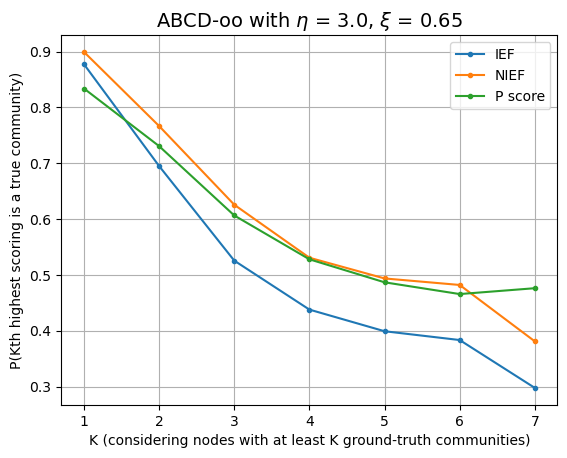

In [6]:
plt.plot(np.arange(MAX)+1, NumIEF/Den, '.-', label='IEF')
plt.plot(np.arange(MAX)+1, NumBeta/Den, '.-', label='NIEF')
#plt.plot(np.arange(MAX)+1, NumC/Den, '.-', label='C')
plt.plot(np.arange(MAX)+1, NumPv/Den, '.-', label='P score')
plt.xlabel('K (considering nodes with at least K ground-truth communities)')
plt.ylabel('P(Kth highest scoring is a true community)')
plt.legend()
plt.grid()
plt.title(r'ABCD-oo with $\eta$ = '+str(ETA)+r', $\xi$ = '+str(XI), fontsize=14);
fn = 'abcdoo_ranked_'+str(XI)+'_'+str(ETA)+'.png'
plt.savefig(fn);


# WAW Paper Figure 3 - ROC curves for Outliers

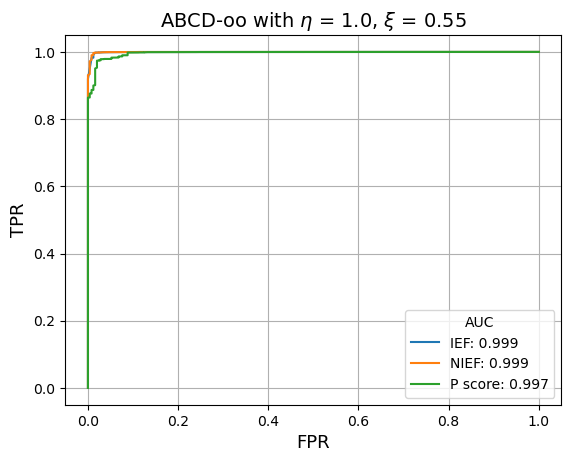

In [7]:
### (2) Classify outliers - ROC curves
num_out = 250
ETA = 1.0
XI = 0.55

g = readGraph(xi=XI, eta=ETA, rep=1)
g.vs['gt'] = [x[0] for x in g.vs['comms']] ## pick the first; 0 == outlier
A = g.get_adjacency_sparse()

## Leiden:
g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
IEF, Beta, C, Pv, DegPart = CAS(A, partition2sparse(g.vs['leiden']))

y = [int(x>0) for x in g.vs['gt']]
g.vs['IEF'] = IEF.max(axis=1).toarray().flatten()
fpr, tpr, thresholds = roc_curve(y, g.vs['IEF'], pos_label=1)
auc = AUC(y, g.vs['IEF'])
plt.plot(fpr, tpr, label='IEF: '+str(round(auc,3)))

g.vs['beta'] = Beta.max(axis=1).toarray().flatten()
fpr, tpr, thresholds = roc_curve(y, g.vs['beta'], pos_label=1)
auc = AUC(y, g.vs['beta'])
plt.plot(fpr, tpr, label='NIEF: '+str(round(auc,3)))

g.vs['Pv'] = Pv.max(axis=1).toarray().flatten()
fpr, tpr, thresholds = roc_curve(y, g.vs['Pv'], pos_label=1)
auc = AUC(y, g.vs['Pv'])
plt.plot(fpr, tpr, label='P score: '+str(round(auc,3)))
plt.grid()
plt.xlabel('FPR', fontsize=13)
plt.ylabel('TPR', fontsize=13)
plt.legend(title='AUC')
plt.title(r'ABCD-oo with $\eta$ = '+str(ETA)+r', $\xi$ = '+str(XI), fontsize=14);
plt.savefig('abcdoo_ROC_scores_eta_'+str(ETA)+'_xi_'+str(XI)+'.png')


# WAW Paper Figures 8-10: EgoSplit + NIEF

Also tried CPM, no use

We use a variation of the ego-split clustering method proposed in [Epasto] and presented in [Book], where we use ensemble clustering after splitting node into multiple copies depending on their respective neighbourhoods.
Since eg-splitting tends to produce many very small communities, we set a minimum size of 10 for the communities.
We compare the resulting ES communities with the GT, followed by one round of applying the NIEF CAS score to update the communities w.r.t. a range of threshold values. 

In practical applications, since the GT is unknown, it is not always clear how to pick a good threshold when using CAS scores.
We present some possible methods by computing respectively the average number of communities (for non-outlier nodes) and the number of outlier nodes for several choices of threshold values.


NIEF: measures suggest at least .1, more for small eta ... ok?


In [9]:
fn = 'Results/egosplit_nief.pkl'
with open(fn,'rb') as fp:
    df = pickle.load(fp)

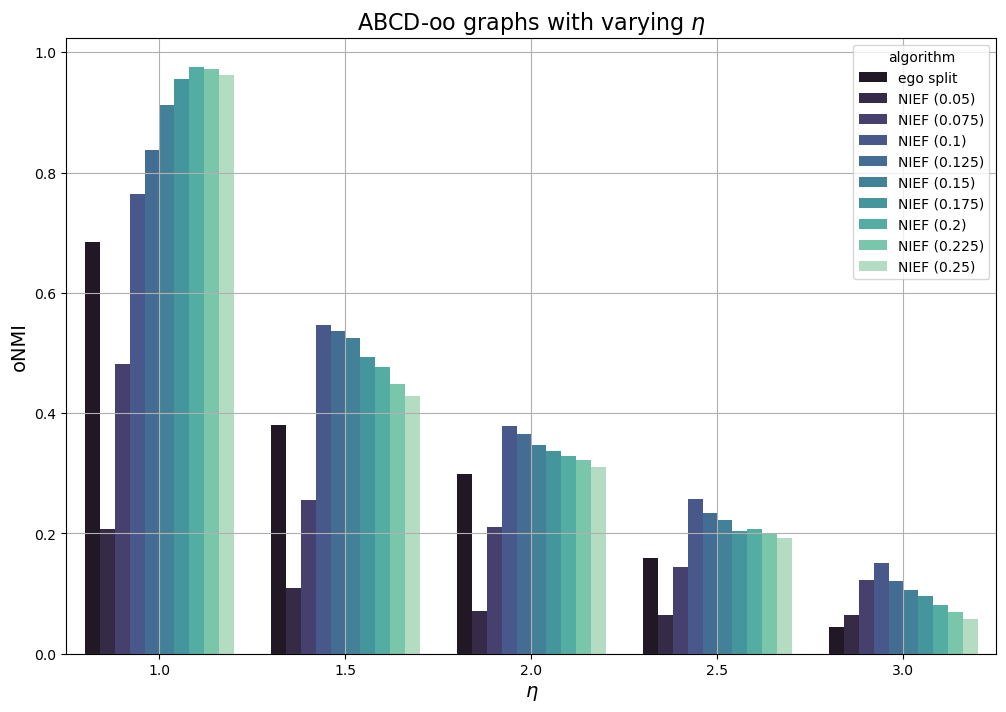

In [10]:
plt.figure(figsize=(12,8))
sns.barplot(x="eta", y="onmi", hue="algorithm", data=df, palette='mako')
plt.xlabel(r'$\eta$', fontsize=14);
plt.ylabel('oNMI', fontsize=14)
plt.grid()
plt.title('ABCD-oo graphs with varying $\eta$', fontsize=16);
plt.savefig('ego_1.png')

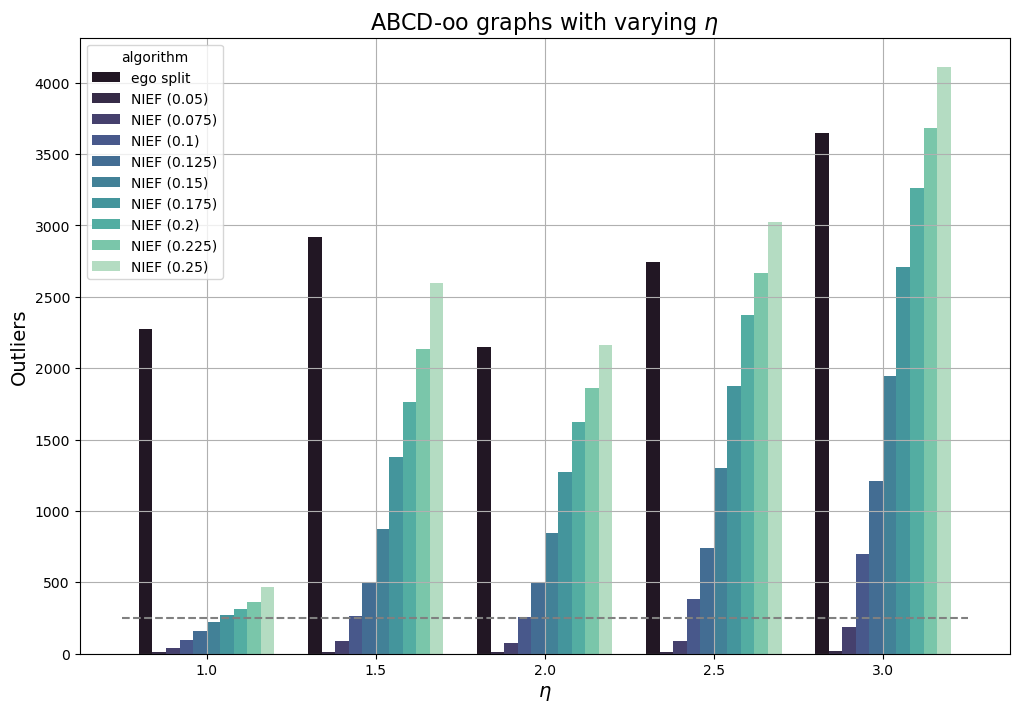

In [11]:
plt.figure(figsize=(12,8))
sns.barplot(x="eta", y="outliers", hue="algorithm", data=df, palette='mako');
plt.xlabel(r'$\eta$', fontsize=14);
plt.ylabel('Outliers', fontsize=14)
plt.hlines(250,-0.5,4.5, color='grey', linestyle='dashed')
plt.grid()
plt.title('ABCD-oo graphs with varying $\eta$', fontsize=16);
plt.savefig('ego_2.png')


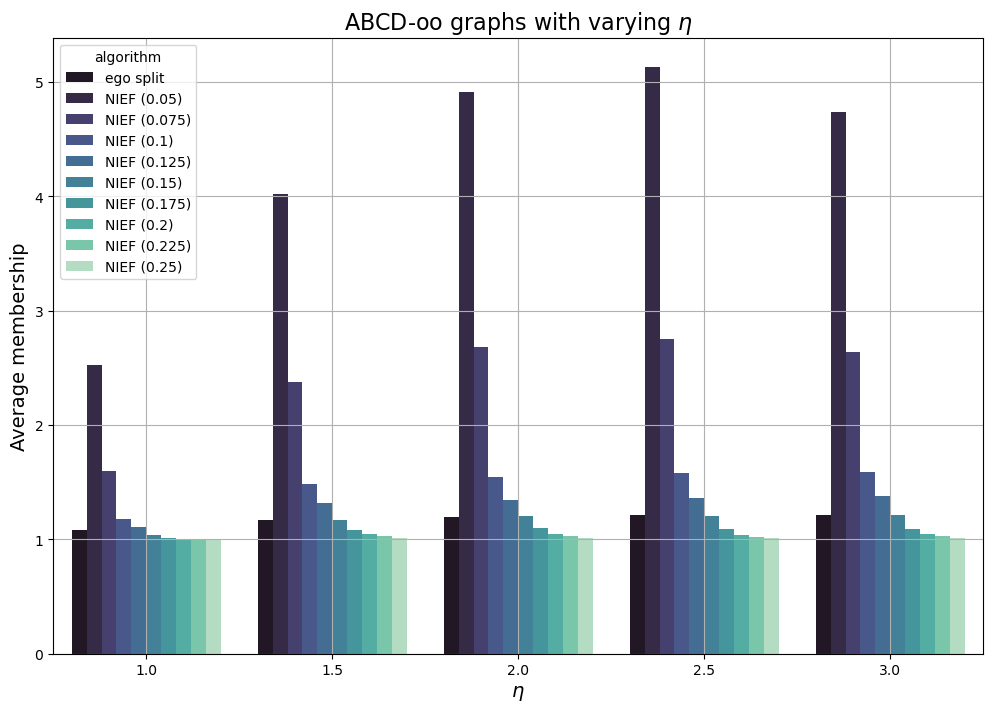

In [12]:
plt.figure(figsize=(12,8))
sns.barplot(x="eta", y="avg_membership", hue="algorithm", data=df, palette='mako');
plt.xlabel(r'$\eta$', fontsize=14);
plt.ylabel('Average membership', fontsize=14)
plt.grid()
plt.title('ABCD-oo graphs with varying $\eta$', fontsize=16);
plt.savefig('ego_3.png')


# WAW Paper - vary eta and look at fraction in 1-2-3... communities


In [13]:
ETA = [1.0,1.5,2.0,2.5,3.0]
V = []
for i in range(len(ETA)):
    eta = ETA[i]
    X = []
    for rep in [1,2,3,4,5,6,7,8,9,10]:
        G = readGraph(xi=0.35, eta=eta, rep=rep)
        G.vs['name'] = [str(i) for i in np.arange(G.vcount())]
        X.extend([len(x) for x in G.vs['comms'] if x[0]!=0])
    V.append(X)
m = max([i for j in V for i in j])
s = len(V[4])


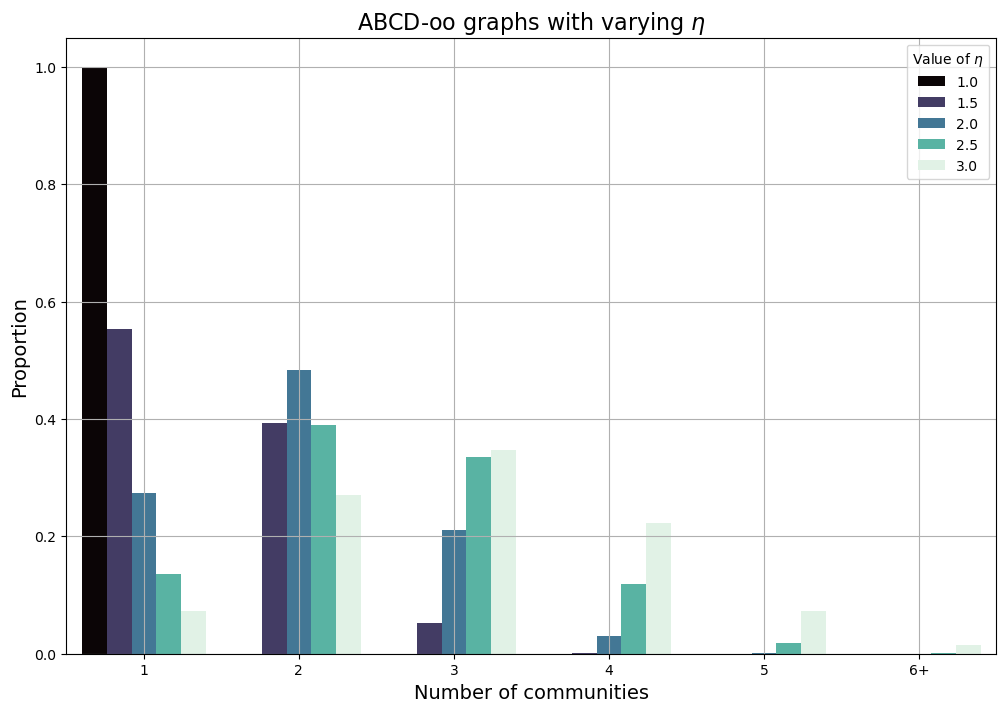

In [15]:
M = 6
A = np.zeros(shape=(5,M))
for i in range(5):
    C = Counter(V[i])
    for j in range(m):
        if j<M-1:
            A[i,j] = C[j+1]
        else:
            A[i,M-1] += C[j+1] 
            
df = pd.DataFrame()
df['memberships'] = [str(x) if x<M else str(M)+'+' for x in np.tile(np.arange(M)+1,5)]
df['eta'] = np.repeat(ETA, M)
df['proportion'] = A.flatten()/s
df.head()


plt.figure(figsize=(12,8))
sns.barplot(x="memberships", y="proportion", hue="eta", data=df, palette='mako');
plt.xlabel('Number of communities', fontsize=14);
plt.ylabel('Proportion', fontsize=14)
plt.grid()
plt.legend(title=r'Value of $\eta$')
plt.title('ABCD-oo graphs with varying $\eta$', fontsize=16);
plt.savefig('abcdoo_eta.png')


# WAW Figure - Values of NIEF for nodes in k communities

To compare with DBLP


In [16]:
G = readGraph(xi=0.15, eta=2.5, rep=1)
G.vs['name'] = [str(i) for i in np.arange(G.vcount())]
## GT community membership matrix
X = np.repeat(np.arange(G.vcount(), dtype=int), G.vs['n_comms'])
Y = np.array([i for j in G.vs['comms'] for i in j])
n = len(X)
M = sparse.csr_matrix( (np.repeat(1,n), (X,Y)), shape=(G.vcount(), max(Y)+1) )
A = G.get_adjacency_sparse()
## Compute CAS measures
IEF, NIEF, C, Pv, DegPart = CAS(A, M, alpha=1)


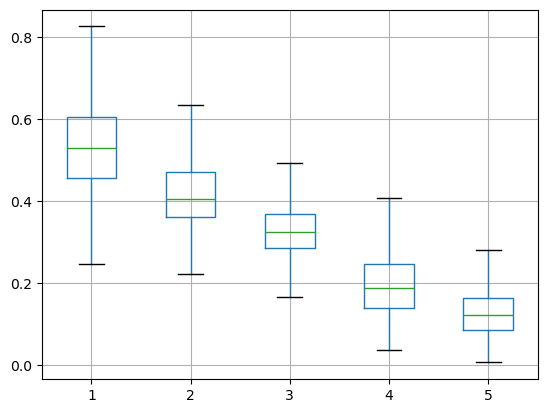

In [17]:
L = []
for i in range(G.vcount()):
    if G.vs[i]['n_comms'] == 3:
        L.append(np.sort(np.array(NIEF[i].todense())[0])[-5:])
df = pd.DataFrame(L, columns=[5,4,3,2,1])
df.boxplot(column=[1,2,3,4,5], showfliers=False);

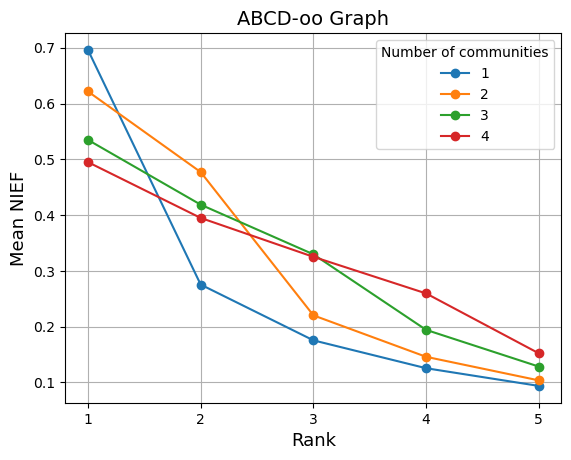

In [19]:
for x in [1,2,3,4]:
    L = []
    for i in range(G.vcount()):
        if G.vs[i]['n_comms'] == x:
            L.append(np.sort(np.array(NIEF[i].todense())[0])[-5:][::-1])
    df = pd.DataFrame(L, columns=['1','2','3','4','5'])
    plt.plot(df.mean(),'o-',label=str(x))
plt.grid()
plt.legend(title='Number of communities')
plt.xlabel('Rank', fontsize=13)
plt.ylabel('Mean NIEF', fontsize=13)
plt.title('ABCD-oo Graph', fontsize=14)
#plt.show()
plt.savefig('abcdoo_rank.png')


## Power-law fit, community sizes

In [20]:
import powerlaw
S = []
for eta in [1.0,1.5,2.0,2.5,3.0]:
    for rep in [1,2,3,4,5,6,7,8,9,10]:
        G = readGraph(xi=0.15, eta=eta, rep=rep)
        S.extend([x[1] for x in Counter([i for j in G.vs['comms'] for i in j]).items()])
## estimates for l' (xmin) and gamma (alpha)
X = powerlaw.Fit(S)
print("\ngamma:", X.power_law.alpha)
print("l':", X.power_law.xmin)
print("KS statistic:", X.power_law.D)


Calculating best minimal value for power law fit
xmin progress: 99%
gamma: 1.8502417820258388
l': 50.0
KS statistic: 0.08878057821380364


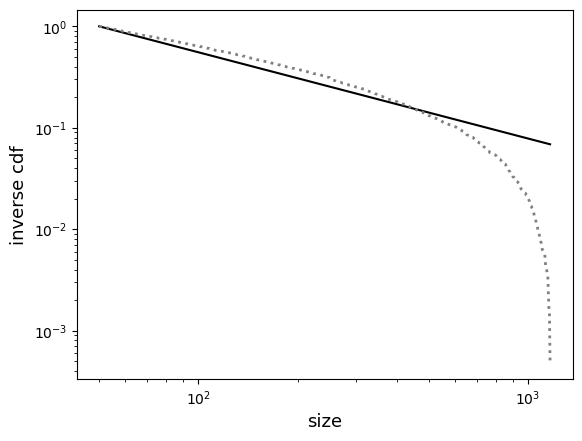

In [21]:
## Starting from l'
fig1 = X.power_law.plot_ccdf(color="black", linestyle="-")
fig1 = X.plot_ccdf(ax=fig1, linewidth=2, color="gray", original_data=False, linestyle=":")
fig1.set_xlabel("size", fontsize=13)
fig1.set_ylabel("inverse cdf", fontsize=13);

In [22]:
G = readGraph(xi=0.15, eta=2.5, rep=1)
Communities = mems2comms([x for x in G.vs['comms']])


In [23]:
def Jac(a,b):
    return len(set(a).intersection(set(b)))#/ len(set(a).union(set(b)))

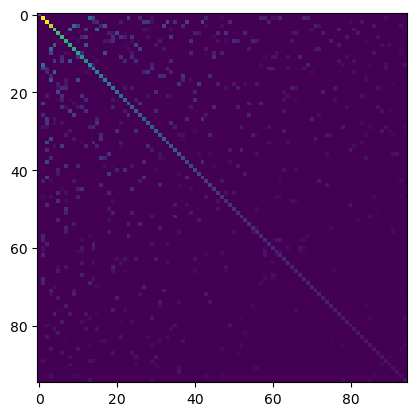

In [24]:
d = np.array(G.degree())/sum(G.degree())
n = G.vcount()
J = np.zeros((95,95))
R = np.zeros((95,95))
for i in range(95):
    for j in range(95):
        J[i,j] = Jac(Communities[i],Communities[j])
        v1 = np.random.choice(n, len(Communities[i]), replace=False, p=d)
        v2 = np.random.choice(n, len(Communities[j]), replace=False, p=d)        
        R[i,j] = Jac(v1,v2)
plt.imshow(J);


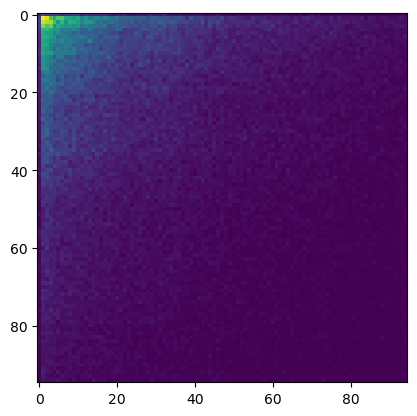

In [25]:
plt.imshow(R);


In [37]:
np.mean(R.flatten())

9.96

In [38]:
## community intersections?

for i in range(94):
    for j in range(i+1,95):
        l1 = len(Communities[i])
        l2 = len(Communities[j])
        v1 = np.random.choice(n, l1, replace=False, p=d)
        v2 = np.random.choice(n, l2, replace=False, p=d)
        L.append([Jac(Communities[i],Communities[j]) , Jac(v1,v2)])
        

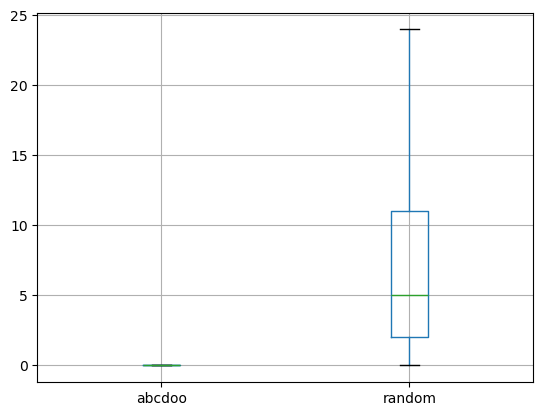

In [39]:
df  = pd.DataFrame(L, columns=['abcdoo','random'])
df.boxplot(showfliers=False);


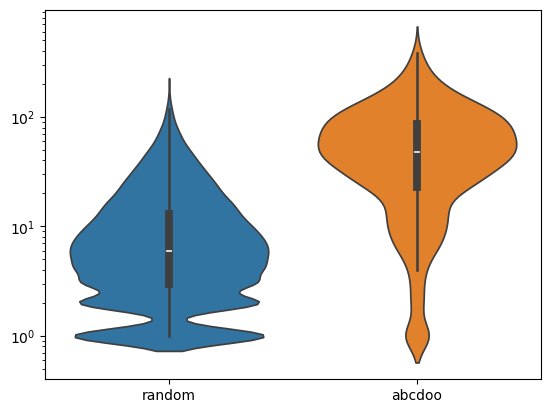

In [40]:
sns.violinplot([df.random[df.random>0],df.abcdoo[df.abcdoo>0]], log_scale=True);

## (1) AMI vs dropped nodes, ABCD-oo with eta == 1

* (1a) use different scores to rank the nodes (w.r.t. outlyingness), but final score w.r.t. Leiden partition
* (1b) actually use the scores for ranking AND scoring


0.35
0.4
0.45
0.5
0.55
0.575
0.6
0.625
0.65


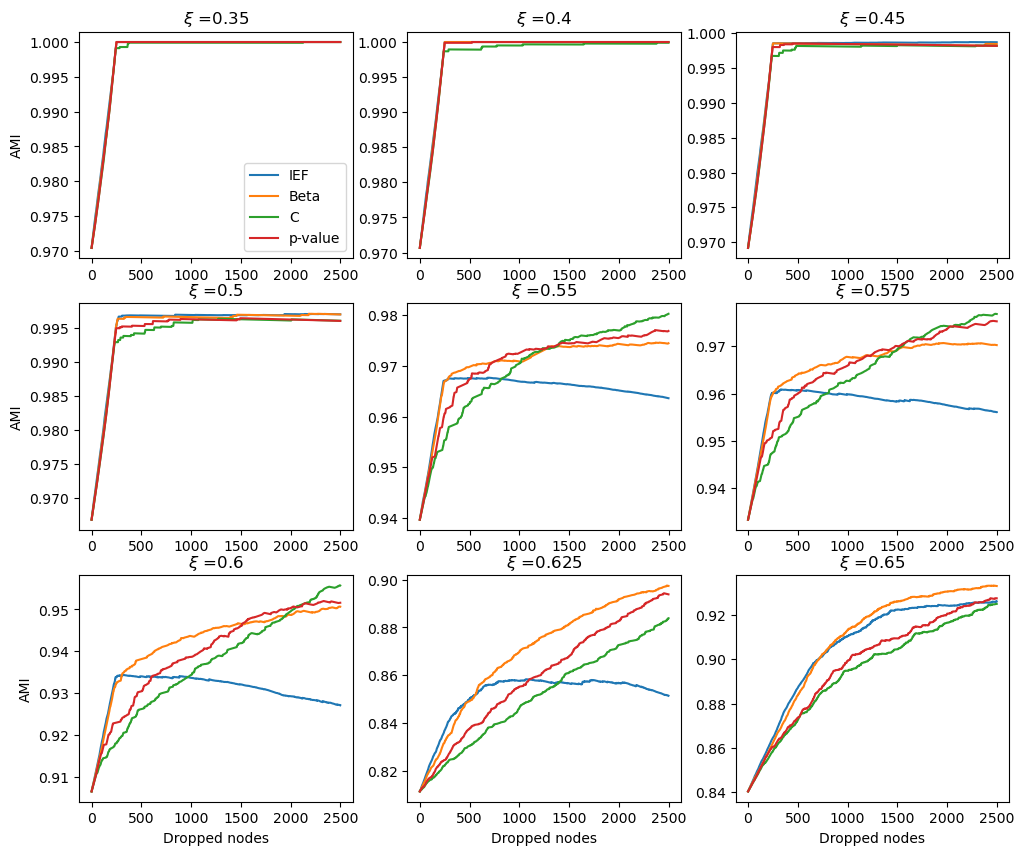

In [41]:
## Scores - only dropping 'outliers'
XIs = [.35,.4,.45,.5,.55,.575,.6,.625,.65]
REP = 1
L = []
for i in range(len(XIs)):
    xi = XIs[i]
    print(xi)
    for rep in range(REP):
        g = readGraph(xi=xi, eta=1.0, rep=rep+1)
        num_nodes = g.vcount()
        A = g.get_adjacency_sparse()
        g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
        g.vs['gt'] = [x[0] for x in g.vs['comms']]
        ## Compute Beta, C; M is the community membership matrix w.r.t. C and c_star 
        IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
        g.vs['IEF'] = IEF.max(axis=1).toarray().flatten()
        g.vs['beta'] = Beta.max(axis=1).toarray().flatten()
        g.vs['C'] = C.max(axis=1).toarray().flatten()
        g.vs['P'] = P.max(axis=1).toarray().flatten()

        ## rank w.r.t. top score, AMI w.r.t. original partition
        r = np.argsort(g.vs['IEF'])
        for k in range(num_nodes//4):
            L.append([xi, 'IEF', k, AMI( np.array(g.vs['leiden'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['beta'])
        for k in range(num_nodes//4):
            L.append([xi, 'beta', k, AMI( np.array(g.vs['leiden'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['C'])
        for k in range(num_nodes//4):
            L.append([xi, 'C', k, AMI( np.array(g.vs['leiden'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['P'])
        for k in range(num_nodes//4):
            L.append([xi, 'P', k, AMI( np.array(g.vs['leiden'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        

plt.figure(figsize=(12,10))
df = pd.DataFrame(L, columns=['xi','algo','dropped','ami']) 
for i in range(len(XIs)):
    xi = XIs[i]
    plt.subplot(3,3,i+1)
    D = df[df.xi==XIs[i]]
    D = D.groupby(by=['dropped','algo'])['ami'].mean()
    plt.plot(D.loc[:,'IEF'].index, D.loc[:,'IEF'], label='IEF')
    plt.plot(D.loc[:,'beta'].index, D.loc[:,'beta'], label='Beta')
    plt.plot(D.loc[:,'C'].index, D.loc[:,'C'], label='C')
    plt.plot(D.loc[:,'P'].index, D.loc[:,'P'], label='p-value')
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('Dropped nodes')
    if i%3==0:
        plt.ylabel('AMI');
    plt.title(r'$\xi$ ='+str(xi))
#plt.savefig('AMI_leiden.png');


0.35
0.4
0.45
0.5
0.55
0.575
0.6
0.625
0.65


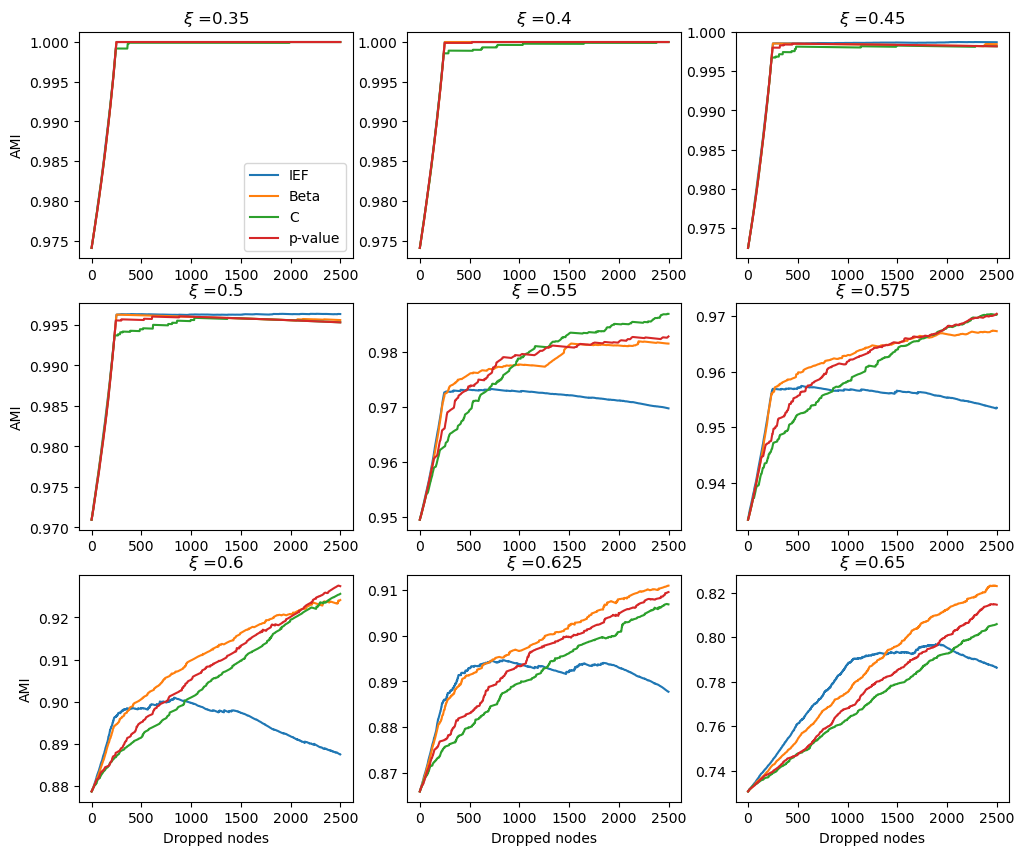

In [42]:
## Scores - using those
L = []
for i in range(len(XIs)):
    xi = XIs[i]
    print(xi)
    for rep in range(REP):
        g = readGraph(xi=xi, eta=1.0, rep=rep+1)
        num_nodes = g.vcount()
        A = g.get_adjacency_sparse()
        g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
        g.vs['gt'] = [x[0] for x in g.vs['comms']]
        ## Compute Beta, C; M is the community membership matrix w.r.t. C and c_star 
        IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
        g.vs['IEF'] = IEF.max(axis=1).toarray().flatten()
        g.vs['IEF_top'] = np.array(IEF.argmax(axis=1)).flatten()
        g.vs['beta'] = Beta.max(axis=1).toarray().flatten()
        g.vs['beta_top'] = np.array(IEF.argmax(axis=1)).flatten()
        g.vs['C'] = C.max(axis=1).toarray().flatten()
        g.vs['C_top'] = np.array(IEF.argmax(axis=1)).flatten()
        g.vs['P'] = P.max(axis=1).toarray().flatten()
        g.vs['P_top'] = np.array(IEF.argmax(axis=1)).flatten()

        ## rank w.r.t. top score, AMI w.r.t. original partition
        r = np.argsort(g.vs['IEF'])
        for k in range(num_nodes//4):
            L.append([xi, 'IEF', k, AMI( np.array(g.vs['IEF_top'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['beta'])
        for k in range(num_nodes//4):
            L.append([xi, 'beta', k, AMI( np.array(g.vs['beta_top'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['C'])
        for k in range(num_nodes//4):
            L.append([xi, 'C', k, AMI( np.array(g.vs['C_top'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        
        r = np.argsort(g.vs['P'])
        for k in range(num_nodes//4):
            L.append([xi, 'P', k, AMI( np.array(g.vs['P_top'])[r[k:]] , np.array(g.vs['gt'])[r[k:]] )])        

plt.figure(figsize=(12,10))
df = pd.DataFrame(L, columns=['xi','algo','dropped','ami']) 
for i in range(len(XIs)):
    xi = XIs[i]
    plt.subplot(3,3,i+1)
    D = df[df.xi==XIs[i]]
    D = D.groupby(by=['dropped','algo'])['ami'].mean()
    plt.plot(D.loc[:,'IEF'].index, D.loc[:,'IEF'], label='IEF')
    plt.plot(D.loc[:,'beta'].index, D.loc[:,'beta'], label='Beta')
    plt.plot(D.loc[:,'C'].index, D.loc[:,'C'], label='C')
    plt.plot(D.loc[:,'P'].index, D.loc[:,'P'], label='p-value')
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('Dropped nodes')
    if i%3==0:
        plt.ylabel('AMI');
    plt.title(r'$\xi$ ='+str(xi))
#plt.savefig('AMI_scores.png');


## (2) TP vs FP, varying threshold

In [43]:
%%time
ETA = 1.0
range_IEF = np.arange(.05,.501,.025)
range_beta = np.arange(.05,.501,.025)
range_C = np.arange(1,8.001,.25)
range_P = np.arange(.90,1,.0025)
XIs = [.35,.65]
REP = 1
L = []

for xi in XIs:
    g = readGraph(xi=xi, eta=ETA, rep=1)
    g.vs['leiden'] = g.community_leiden(objective_function='modularity').membership
    g.vs['gt'] = [x[0] for x in g.vs['comms']] ## pick the first; 0 == outlier
    A = g.get_adjacency_sparse()
    IEF, Beta, C, P, DegPart = CAS(A, partition2sparse(g.vs['leiden']))
#     for th in range_IEF:
#         M = score_to_memberships(IEF, DegPart, th)
#         L.append(['IEF', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])
    for th in range_beta:
        M = score_to_memberships(Beta, DegPart, th)
        L.append(['Beta', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])
#     for th in range_C:
#         M = score_to_memberships(C, DegPart, th)
#         L.append(['C', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])
#     for th in range_P:
#         M = score_to_memberships(P, DegPart, th)
#         L.append(['P', xi, th, Counter(np.array(M.sum(axis=1)).flatten())[0], sum((np.array(M.sum(axis=1)).flatten() == 0) & (np.array(g.vs['gt']) == 0))])

df = pd.DataFrame(L, columns=['score','xi','threshold','outliers','TP'])
df['FP'] = df['outliers'] - df['TP']


CPU times: user 4.93 s, sys: 70.9 ms, total: 5 s
Wall time: 5.01 s


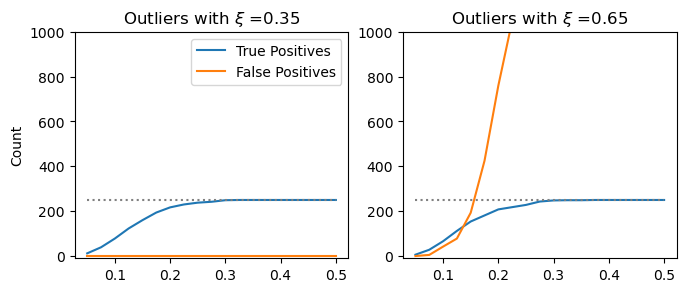

In [44]:
_df = df[df.score == 'Beta']

plt.figure(figsize=(12,10))

for i in range(len(XIs)):
    xi = XIs[i]
    D = _df[_df.xi == xi]
    plt.subplot(3,3,i+1)
    plt.plot(D.threshold, D.TP, label='True Positives')
    plt.plot(D.threshold, D.FP, label='False Positives')
    plt.hlines(y=num_out, xmin=min(D.threshold), xmax=max(D.threshold), linestyles='dotted', color='grey')
    plt.ylim((-10,1000))
    if i==0:
        plt.legend()
    if i>5:
        plt.xlabel('threshold')
    if i%3==0:
        plt.ylabel('Count');
    plt.title(r'Outliers with $\xi$ ='+str(xi)) 
#plt.savefig('abcdoo_TP_FP_Beta_eta_3_0.png');    


## More tests - as with DBLP


In [45]:
XI = 0.35
ETA = 1.5
REP = 1

G = readGraph(xi=XI, eta=ETA, rep=REP)
G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
G.vs['gt'] = [x[0] for x in G.vs['comms']] ## pick the first; 0 == outlier
## Add community degrees to G (deg_A(v)'s)
for v in G.vs:
    ctr = Counter([i for x in v.neighbors() for i in x['comms']])
    v['degrees'] = [ctr[i] if i in ctr.keys() else 0 for i in v['comms'] ]

A = G.get_adjacency_sparse()
IEF, Beta, C, Pv, DegPart = CAS(A, partition2sparse(G.vs['leiden']), alpha=1)

In [46]:
## Thresholds below are somewhat arbitrary

M = score_to_memberships(IEF, DegPart, threshold=.2)
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('IEF:')
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([G.vs[i]['gt']==0 for i in outliers]))

M = score_to_memberships(Beta, DegPart, threshold=.2)
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('\nBeta score:')
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([G.vs[i]['gt']==0 for i in outliers]))

M = score_to_memberships(C, DegPart, threshold=3)
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('\nC score:')
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([G.vs[i]['gt']==0 for i in outliers]))

M = score_to_memberships(Pv, DegPart, threshold=.95)
outliers = np.where(np.array(M.sum(axis=1).flatten().tolist()[0])==0)[0]
print('\np-value score:')
print('outliers found:',len(outliers))
print('ground-truth outliers found:',sum([G.vs[i]['gt']==0 for i in outliers]))


IEF:
outliers found: 51
ground-truth outliers found: 51

Beta score:
outliers found: 279
ground-truth outliers found: 206

C score:
outliers found: 566
ground-truth outliers found: 216

p-value score:
outliers found: 240
ground-truth outliers found: 163


## (3) Distributions - true communities vs all non-zeros

Nodes in 3 communities

* Input: membership (sparse) matrix M and (Sparse) adjacency A


CPU times: user 9.77 s, sys: 132 ms, total: 9.9 s
Wall time: 9.37 s


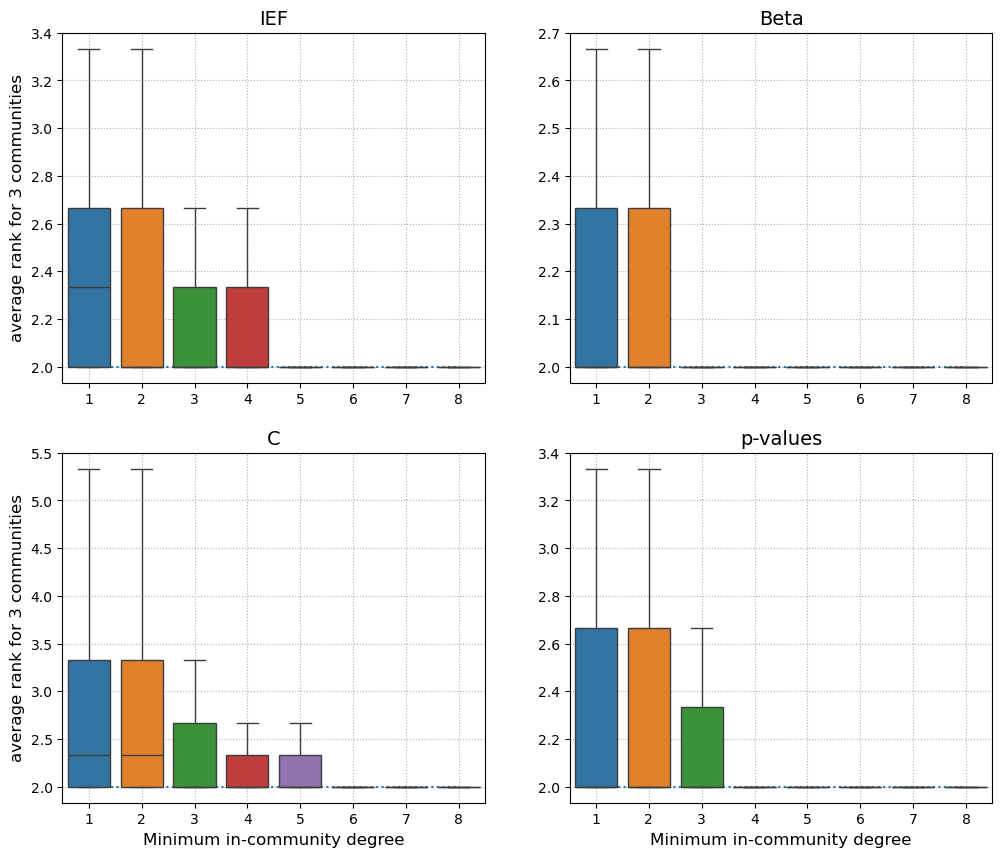

In [47]:
%%time
plt.style.use('default')
K = 3
for xi in [0.5]:
    for eta in [3.0]:
        G = readGraph(xi=xi, eta=eta, rep=1)
        G.vs['leiden'] = G.community_leiden(objective_function='modularity').membership
        G.vs['gt'] = [x[0] for x in G.vs['comms']] ## pick the first; 0 == outlier

        ## Add community degrees to G (deg_A(v)'s)
        for v in G.vs:
            ctr = Counter([i for x in v.neighbors() for i in x['comms']])
            v['degrees'] = [ctr[i] if i in ctr.keys() else 0 for i in v['comms'] ]

        ## GT community membership matrix
        X = np.repeat(np.arange(G.vcount(), dtype=int), G.vs['n_comms'])
        Y = np.array([i for j in G.vs['comms'] for i in j])
        n = len(X)
        M = sparse.csr_matrix( (np.repeat(1,n), (X,Y)), shape=(G.vcount(), max(Y)+1) )
        A = G.get_adjacency_sparse()

        ## Compute CAS measures
        IEF, Beta, C, Pv, DegPart = CAS(A, M, alpha=1)
        
        ## compute average 
        V = np.array(G.vs['n_comms']) == K
        GT = np.array([G.vs[v]['comms'] for v in np.where(V)])[0] 
        Degs = np.array([G.vs[v]['degrees'] for v in np.where(V)])[0]        

        plt.figure(figsize=(12,10))
        ## IEF
        X = IEF[V]
        L = []
        for i in range(GT.shape[0]):
            x = np.argsort(X[i].toarray()[0])[::-1]
            L.append([np.where(x==GT[i][j])[0][0] for j in range(K) ])
        df = pd.DataFrame(np.array(L)+1)
        my_dict = {}
        for j in [1,2,3,4,5,6,7,8]:
            _df = df[np.min(Degs, axis=1) >= j]
            x = _df.mean(axis=1)
            my_dict[str(j)] = list(x)
        plt.subplot(221)
        plt.hlines((K+1)/2,0,7,linestyles='dotted')
        ax = sns.boxplot([x for x in my_dict.values()], showfliers=False, );
        ax.set_xticks(np.arange(8))
        ax.grid(linestyle=':')
        ax.set_xticklabels(my_dict.keys())
        plt.ylabel('average rank for '+str(K)+' communities', fontsize=12);
        plt.title('IEF', fontsize=14);

        ## Beta
        X = Beta[V]
        L = []
        for i in range(GT.shape[0]):
            x = np.argsort(X[i].toarray()[0])[::-1]
            L.append([np.where(x==GT[i][j])[0][0] for j in range(K) ])
        df = pd.DataFrame(np.array(L)+1)
        my_dict = {}
        for j in [1,2,3,4,5,6,7,8]:
            _df = df[np.min(Degs, axis=1) >= j]
            x = _df.mean(axis=1)
            my_dict[str(j)] = list(x)
        plt.subplot(222)
        plt.hlines((K+1)/2,0,7,linestyles='dotted')
        ax = sns.boxplot([x for x in my_dict.values()], showfliers=False, );
        ax.set_xticks(np.arange(8))
        ax.grid(linestyle=':')
        ax.set_xticklabels(my_dict.keys())
        #plt.xlabel('min community degree at least');
        #plt.ylabel('average rank for '+str(K)+' communities');
        plt.title('Beta', fontsize=14);

        ## C
        X = C[V]
        L = []
        for i in range(GT.shape[0]):
            x = np.argsort(X[i].toarray()[0])[::-1]
            L.append([np.where(x==GT[i][j])[0][0] for j in range(K) ])
        df = pd.DataFrame(np.array(L)+1)
        my_dict = {}
        for j in [1,2,3,4,5,6,7,8]:
            _df = df[np.min(Degs, axis=1) >= j]
            x = _df.mean(axis=1)
            my_dict[str(j)] = list(x)
        plt.subplot(223)
        plt.hlines((K+1)/2,0,7,linestyles='dotted')
        ax = sns.boxplot([x for x in my_dict.values()], showfliers=False, );
        ax.set_xticks(np.arange(8))
        ax.grid(linestyle=':')
        ax.set_xticklabels(my_dict.keys())
        plt.xlabel('Minimum in-community degree', fontsize=12);
        plt.ylabel('average rank for '+str(K)+' communities', fontsize=12);
        plt.title('C', fontsize=14);

        ## Pv
        X = Pv[V]
        L = []
        for i in range(GT.shape[0]):
            x = np.argsort(X[i].toarray()[0])[::-1]
            L.append([np.where(x==GT[i][j])[0][0] for j in range(K) ])
        df = pd.DataFrame(np.array(L)+1)
        my_dict = {}
        for j in [1,2,3,4,5,6,7,8]:
            _df = df[np.min(Degs, axis=1) >= j]
            x = _df.mean(axis=1)
            my_dict[str(j)] = list(x)
        plt.subplot(224)
        plt.hlines((K+1)/2,0,7,linestyles='dotted')
        ax = sns.boxplot([x for x in my_dict.values()], showfliers=False, );
        ax.set_xticks(np.arange(8))
        ax.grid(linestyle=':')
        ax.set_xticklabels(my_dict.keys())
        plt.xlabel('Minimum in-community degree', fontsize=12);
        #plt.ylabel('average rank for '+str(K)+' communities');
        plt.title('p-values', fontsize=14);

        ## save PNG
        fn = 'abcdoo_'+str(xi)+'_'+str(eta)+'_'+str(K)+'.png'
        #plt.savefig(fn)


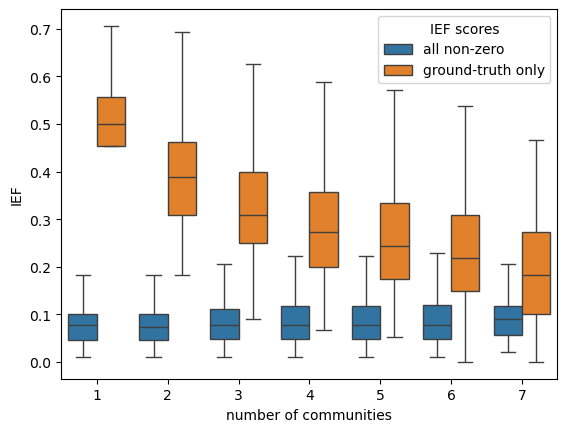

In [48]:
score = []
gt = []
nc = []
for ctr in np.arange(1,MAX+1):
    V = np.array(G.vs['n_comms']) == ctr
    for i in range(len(V)):
        if V[i]:
            x = IEF[i].toarray()[0]
            y = np.array(G.vs[i]['comms'])
            score.extend([x[i] for i in y])
            gt.extend(np.repeat(True,len(y)))
            score.extend(x[x>0])
            gt.extend(np.repeat(False,sum(x>0)))
            nc.extend(np.repeat(ctr,len(y)+sum(x>0)))
D = pd.DataFrame( np.array([score,gt,nc]).transpose(), columns=['IEF','gt','number of communities'])
D['number of communities'] = [int(x) for x in D['number of communities']]
g = sns.boxplot(x='number of communities', y='IEF', hue='gt', data=D, 
                showfliers=False, legend='full')
leg = g.axes.get_legend()
leg.set_title('IEF scores')
new_labels = ['all non-zero','ground-truth only']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
fn = 'abcdoo_ied_0.5_3.0.png'
plt.savefig(fn);


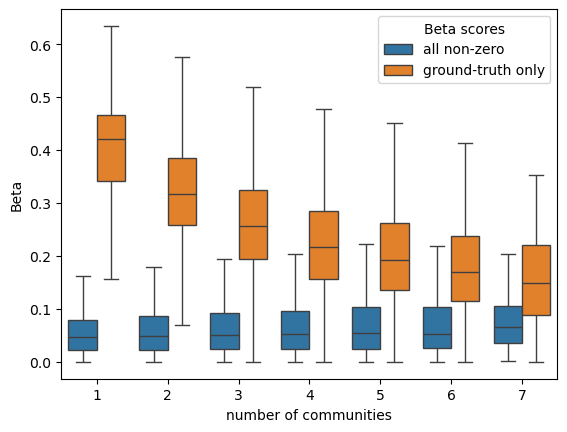

In [49]:
score = []
gt = []
nc = []
for ctr in np.arange(1,MAX+1):
    V = np.array(G.vs['n_comms']) == ctr
    for i in range(len(V)):
        if V[i]:
            x = Beta[i].toarray()[0]
            y = np.array(G.vs[i]['comms'])
            score.extend([x[i] for i in y])
            gt.extend(np.repeat(True,len(y)))
            score.extend(x[x>0])
            gt.extend(np.repeat(False,sum(x>0)))
            nc.extend(np.repeat(ctr,len(y)+sum(x>0)))
D = pd.DataFrame( np.array([score,gt,nc]).transpose(), columns=['Beta','gt','number of communities'])
D['number of communities'] = [int(x) for x in D['number of communities']]
g = sns.boxplot(x='number of communities', y='Beta', hue='gt', data=D, 
                showfliers=False, legend='full')
leg = g.axes.get_legend()
leg.set_title('Beta scores')
new_labels = ['all non-zero','ground-truth only']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
fn = 'abcdoo_beta_0.5_3.0.png'
plt.savefig(fn);


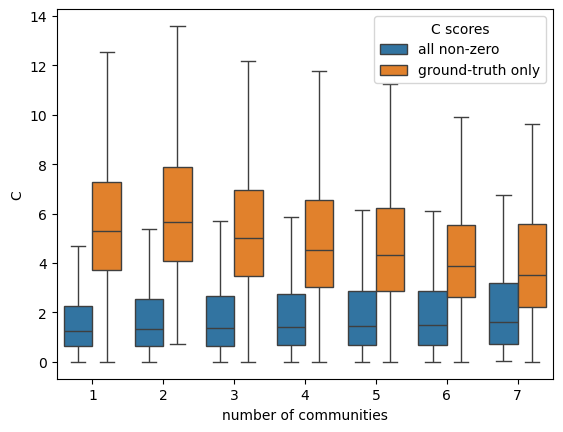

In [50]:
score = []
gt = []
nc = []
for ctr in np.arange(1,MAX+1):
    V = np.array(G.vs['n_comms']) == ctr
    for i in range(len(V)):
        if V[i]:
            x = C[i].toarray()[0]
            y = np.array(G.vs[i]['comms'])
            score.extend([x[i] for i in y])
            gt.extend(np.repeat(True,len(y)))
            score.extend(x[x>0])
            gt.extend(np.repeat(False,sum(x>0)))
            nc.extend(np.repeat(ctr,len(y)+sum(x>0)))
D = pd.DataFrame( np.array([score,gt,nc]).transpose(), columns=['C','gt','number of communities'])
D['number of communities'] = [int(x) for x in D['number of communities']]
g = sns.boxplot(x='number of communities', y='C', hue='gt', data=D, 
                showfliers=False, legend='full')
leg = g.axes.get_legend()
leg.set_title('C scores')
new_labels = ['all non-zero','ground-truth only']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
fn = 'abcdoo_c_0.5_3.0.png'
plt.savefig(fn);


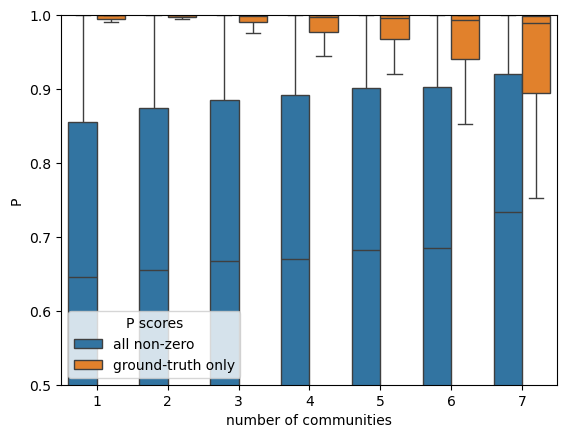

In [51]:
score = []
gt = []
nc = []
for ctr in np.arange(1,MAX+1):
    V = np.array(G.vs['n_comms']) == ctr
    for i in range(len(V)):
        if V[i]:
            x = Pv[i].toarray()[0]
            y = np.array(G.vs[i]['comms'])
            score.extend([x[i] for i in y])
            gt.extend(np.repeat(True,len(y)))
            score.extend(x[x>0])
            gt.extend(np.repeat(False,sum(x>0)))
            nc.extend(np.repeat(ctr,len(y)+sum(x>0)))
D = pd.DataFrame( np.array([score,gt,nc]).transpose(), columns=['P','gt','number of communities'])
D['number of communities'] = [int(x) for x in D['number of communities']]
g = sns.boxplot(x='number of communities', y='P', hue='gt', data=D, 
                showfliers=False, legend='full')
leg = g.axes.get_legend()
leg.set_title('P scores')
new_labels = ['all non-zero','ground-truth only']
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
plt.ylim(.5,1);
fn = 'abcdoo_p_0.5_3.0.png'
plt.savefig(fn);


# Extras

## Testing Rising Tide Stuff

In [ ]:
G = readGraph(xi=0.4, eta=1.5, rep=1)
A = G.get_adjacency_sparse()
M = partition2sparse(G.community_leiden(objective_function='modularity').membership)
IEF, Beta, C, Pv, DegPart = CAS(A,M)
Counter(np.array(M.sum(axis=1)).flatten())


In [ ]:
B = score_to_memberships(Beta, DegPart, threshold=.2, min_deg_in=2)
Counter(np.array(B.sum(axis=1)).flatten())


In [ ]:
Counter(G.vs['n_comms'] == np.array(B.sum(axis=1)).flatten())

In [ ]:
RT = rising_tide(A, Beta, min_deg_in=2)
Counter(np.array(RT.sum(axis=1)).flatten())


In [ ]:
Counter(G.vs['n_comms'] == np.array(RT.sum(axis=1)).flatten())

In [ ]:
Counter(np.array(RT.sum(axis=1)).flatten())


In [ ]:
G.vs['gt'] = [x[0] for x in G.vs['comms']]

In [ ]:
AMI(G.vs['gt'], G.community_leiden(objective_function='modularity').membership)

In [ ]:
AMI(G.vs['gt'], np.array(Beta.argmax(axis=1)).flatten())

In [ ]:
AMI(G.vs['gt'], np.array(RT.argmax(axis=1)).flatten())

## Testing edges

In [ ]:
G = readGraph(xi=0.4, eta=1.5, rep=1)
## GT community membership matrix
X = np.repeat(np.arange(G.vcount(), dtype=int), G.vs['n_comms'])
Y = np.array([i for j in G.vs['comms'] for i in j])
n = len(X)
M = sparse.csr_matrix( (np.repeat(1,n), (X,Y)), shape=(G.vcount(), max(Y)+1) )
A = G.get_adjacency_sparse()

## Compute CAS measures
IEF, Beta, C, Pv, DegPart = CAS(A, M, alpha=1)


In [ ]:
## Add community degrees to G (deg_A(v)'s)
for v in G.vs:
    ctr = Counter([i for x in v.neighbors() for i in x['comms']])
    v['degrees'] = [ctr[i] if i in ctr.keys() else 0 for i in v['comms'] ]
## set outliers to 0
b = np.where(np.array([x[0]==0 for x in G.vs['comms']]))[0]
for i in b:
    G.vs[i]['n_comms'] = 0
    

In [ ]:
Score = []
Inter = []
for e in G.es:
    Score.append(np.max(np.minimum(np.array(Beta[e.source].todense())[0], np.array(Beta[e.target].todense())[0])))
    Inter.append(len(set(G.vs[e.source]['comms']).intersection(set(G.vs[e.target]['comms']))))


In [ ]:
df = pd.DataFrame()
df['Score'] = Score
df['Intersection'] = Inter
sns.boxplot(y='Score', x='Intersection', data=df)
plt.grid();


In [ ]:
## Leiden
M = partition2sparse(G.community_leiden(objective_function='modularity').membership)
IEF, Beta, C, Pv, DegPart = CAS(A,M)


In [ ]:
Score = []
Inter = []
for e in G.es:
    Score.append(np.max(np.minimum(np.array(Beta[e.source].todense())[0], np.array(Beta[e.target].todense())[0])))
    Inter.append(len(set(G.vs[e.source]['comms']).intersection(set(G.vs[e.target]['comms']))))


In [ ]:
df = pd.DataFrame()
df['Score'] = Score
df['Intersection'] = Inter
sns.boxplot(y='Score', x='Intersection', data=df)
plt.grid();


In [ ]:
## drop edges
E = np.where(np.array(Score)<.1)[0]
G.delete_edges(E)

In [ ]:
G.vs['gt'] = [x[0] for x in G.vs['comms']]

In [ ]:
AMI(G.vs['gt'], G.community_leiden(objective_function='modularity').membership)

In [ ]:
Counter(G.vs['n_comms'])

In [ ]:
Counter(Inter)

## Computing oNMI over a range of threshold values
* This is starting from Leiden, drop it
